# Reference Solution for Assignment "FL Main Flavors"

## 1. Preparation

### 1.1 Libraries

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error

# We will use networx objects to store empircial graphs, local datasets and models
import networkx as nx 
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

### 1.2 Helper functions

In [2]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI):
    num_stations = len(G_FMI.nodes)
    colors = np.array(['black', 'green', 'red', 'brown', 'deeppink',
                        'blue', 'olive', 'gray', 'orange', 'purple'])
    coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    # Create a plot
    fig, ax = plt.subplots()
    # Draw nodes
    for node in G_FMI.nodes:
        color = colors[G_FMI.nodes[node]['cluster']]
        ax.scatter(coords[node,1], coords[node,0], color=color, s=4, zorder=5)  # zorder ensures nodes are on top of edges
        ax.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color=color, fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')
    plt.show()
    
    
# The function connects each FMI station with 
# the nearest neighbours. 
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for iter_i in range(nrnodes): 
        for iter_ii in range(nrnodes): 
            if iter_i != iter_ii : 
                if A[iter_i,iter_ii]> 0 :
                    graph.add_edge(iter_i, iter_ii)
    return graph

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp" 
# returns numpy arrays X, y.
def ExtractFeaureMatrixLabvelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label 
    for ind in range(nrdatapoints):
        # latitude of FMI station, normalized by 100 
        lat = float(data['Latitude'].iloc[ind])/100
        # longitude of FMI station, normalized by 100
        lon = float(data['Longitude'].iloc[ind])/100
        # temperature value of the data point 
        tmp = data['temp'].iloc[ind]
        # read the date and time of the temperature measurement 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

## 2 Data

### 2.1 Dataset

In [3]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
num_stations = len(data.name.unique())
num_datapoints = len(data)

### 2.2 Empirical graph

The empirical graph is connected: True


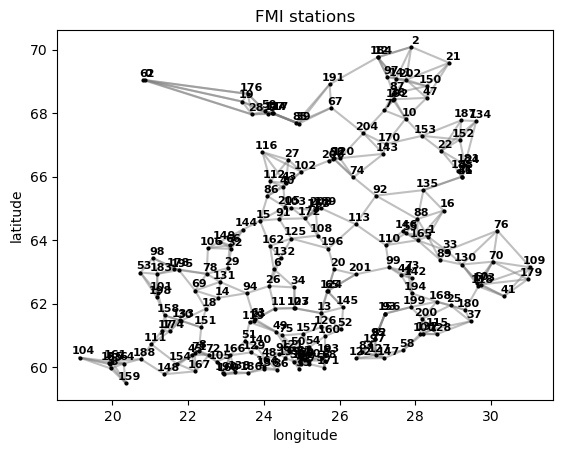

In [4]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, num_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X, y = ExtractFeaureMatrixLabvelVector(station_data)

    localsamplesize = len(y)
    G_FMI.nodes[i]['samplesize'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = np.array([station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]]) # The coordinates of the i-th weather station
    G_FMI.nodes[i]['X'] = X # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y'] = y  # The  label vector for local dataset at node i
    G_FMI.nodes[i]['cluster'] = 0 # The cluster to which the node is assigned (default value = 0)

# Add edges between each station and its nearest neighbors.
# NOTE: the node degree might be different for different nodes.
numneighbors = 4
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

# Visualize the empirical graph.
plotFMI(G_FMI)

## 3. Model

### 3.1 Main hyperparameters

In [5]:
# Define the number of clusters and the random seed.
k = 10
seed = 4740

### 3.2 Student task #1 - K-Means with coordinates as a representation vector.

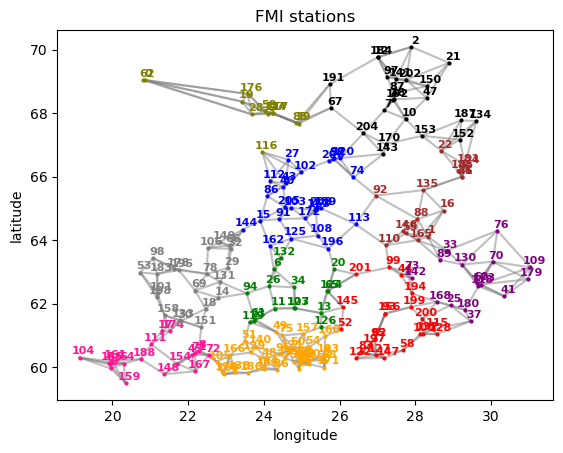

In [6]:
# Create a list of all coordinates.
coordinates = np.array([G_FMI.nodes[i_node]['coord'] for i_node in G_FMI.nodes])

# Fit the K-Means to the representation vector.
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(coordinates)

# Assign cluster labels to the nodes in the graph.
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

# Plot the clustered graph.
plotFMI(G_FMI)

In [7]:
# Create the storage for average temperatures.
avg_temperatures = np.zeros(k)
for cluster in range(k):
    # Define the variable to store the number of data points in the cluster.
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

# Average error over all nodes in the graph.
avg_error = 0
num_datapoints = 0
for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    num_datapoints+=G_FMI.nodes[node]['samplesize']
    avg_error += node_error
    # print(f"The node {node} from the cluster {G_FMI.nodes[node]['cluster']}")
    # print(f"The average cluster temperatuer is {cluster_avg_temp}")
    # print(f"The node error is {node_error}\n")
avg_error /= num_datapoints

# Print the average error.
print(f"The average squared loss over all data points is {avg_error}")

The average squared loss over all data points is 36.41977783638262


### 3.3 Student task #2 - K-Means with GMM parameters as a representation vector.

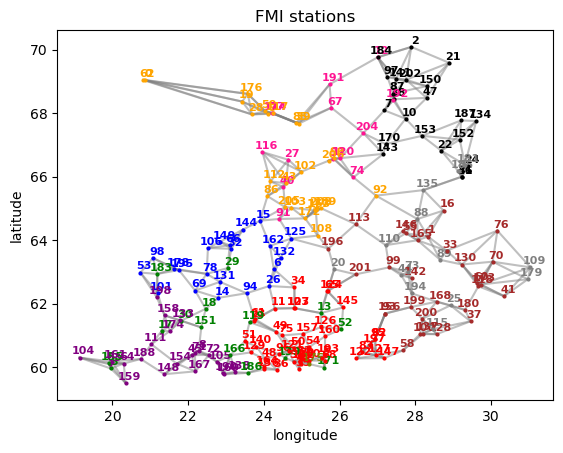

In [8]:
# Define the number components for the GMM. 
n_components = 2

# Fit the nodes to the GMM model and extract the model's parameters.
for node in G_FMI.nodes():
    
    # Extract node's features.
    node_X = G_FMI.nodes[node]['X']
    
    # Fit GMM.
    gmm = GaussianMixture(n_components=n_components, random_state = seed) 
    gmm.fit(node_X)
    
    # Get the parameters of the GMM (mean vectors, covariance matricies, and component weights).
    gmm_params = np.concatenate((np.concatenate((gmm.means_.ravel(), gmm.covariances_.ravel())), gmm.weights_))
    
    # Assign GMM parameters to the node.
    G_FMI.nodes[node]['gmm_params'] = gmm_params

# Get the GMM parameters of all the nodes in the graph.
gmm_params = np.array([G_FMI.nodes[i_node]['gmm_params'] for i_node in G_FMI.nodes])

# Fit the K-Means to the representation vector.
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(gmm_params)

# Assign cluster labels to the nodes in the graph.
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

# Plot the clustered graph.
plotFMI(G_FMI)

In [9]:
# Create the storage for average temperatures.
avg_temperatures = np.zeros(k)
for cluster in range(k):
    # Define the variable to store the number of data points in the cluster.
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

# Average error over all nodes in the graph.
avg_error = 0
num_datapoints=0
for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    num_datapoints+=G_FMI.nodes[node]['samplesize']
    avg_error += node_error
    # print(f"The node {node} from the cluster {G_FMI.nodes[node]['cluster']}")
    # print(f"The average cluster temperatuer is {cluster_avg_temp}")
    # print(f"The node error is {node_error}\n")
avg_error /= num_datapoints

# Print the average error.
print(f"The average squared loss over all data points is {avg_error}")

The average squared loss over all data points is 37.87398173145912


### 3.4 Student task #3 - K-Means with eigenvectors of the Laplacian matrix as a representation vector.

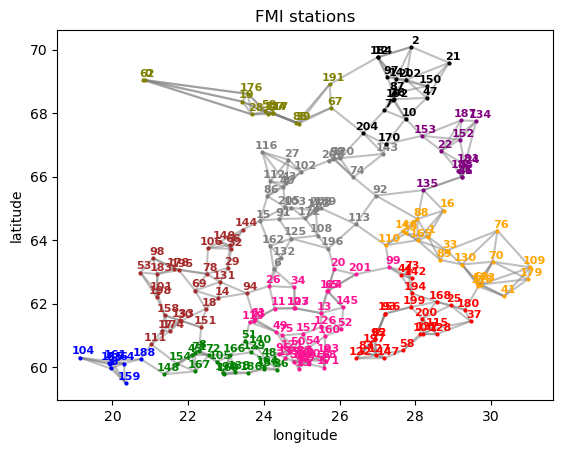

In [10]:
# Construct the Laplacian matrix.
L = nx.laplacian_matrix(G_FMI).toarray()

# Compute eigenvalues and eigenvectors.
eigenvalues, eigenvectors = LA.eig(L)

idx_sorted = np.argsort(eigenvalues)

eigenvalues_sorted = eigenvalues[idx_sorted]
eigenvectors_sorted = eigenvectors.T[idx_sorted]

k_eigen = eigenvectors_sorted[:k]

# Fit the K-Means to the representation vector.
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(k_eigen.T)

# Assign cluster labels to the nodes in the graph
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

# Plot the clustered graph.
plotFMI(G_FMI)

In [11]:
# Create the storage for average temperatures.
avg_temperatures = np.zeros(k)
for cluster in range(k):
    # Define the variable to store the number of data points in the cluster.
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

# Average error over all nodes in the graph.
avg_error = 0
nr_datapoints = 0
for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    avg_error += node_error
    nr_datapoints+=G_FMI.nodes[node]['samplesize']
    # print(f"The node {node} from the cluster {G_FMI.nodes[node]['cluster']}")
    # print(f"The average cluster temperatuer is {cluster_avg_temp}")
    # print(f"The node error is {node_error}\n")
avg_error /= nr_datapoints

# Print the average error.
print(f"The average squared loss over data points is {avg_error}")

The average squared loss over data points is 36.976444247108354
